# FLUXNET Shuttle Library - Complete Example

This notebook demonstrates how to use the `fluxnet_shuttle` to discover, download, and analyze FLUXNET data from AmeriFlux and ICOS networks.

## Overview
The FLUXNET Shuttle Library provides a unified interface to:
- **Discover** available datasets from multiple FLUXNET networks
- **Download** data for specific sites
- **Process** and analyze eddy covariance flux data

## Requirements
- `fluxnet_shuttle`
- `pandas`
- `matplotlib` (for plotting)
- Network connection for data discovery and download

In [ ]:
# Install required packages
# Uncomment and run if packages are not already installed
# !pip install pandas matplotlib

# For development installation of fluxnet-shuttle-lib:
# !pip install -e .

## Setup and Configuration

In [ ]:
import os
import sys
import logging
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

from fluxnet_shuttle import download, listall

In [ ]:
# Configure logging to output to stdout, which Jupyter Notebook captures
logging_level = logging.DEBUG  # Change to logging.DEBUG for more detailed messages

logging.basicConfig(stream=sys.stdout, level=logging_level)

# Create a logger instance
log = logging.getLogger(__name__)
print("Logging configured successfully")

Logging configured successfully


## Step 1: Discover Available Data

Use `listall()` to get a comprehensive list of all available FLUXNET datasets from AmeriFlux and ICOS networks.

**Note:** This step may take 1-2 minutes as it queries both AmeriFlux and ICOS APIs to build download records for each site.

In [ ]:
# Download a list of all available FLUXNET datasets from AmeriFlux and ICOS
# N.B.: listing AmeriFlux sites takes a while (about 1-2 minutes) because a download record is created for each site
csv_filename = await listall(ameriflux=True, icos=True)
print(f"\nData catalog saved to: {csv_filename}")

DEBUG:fluxnet_shuttle_lib.shuttle:Starting listall with (), {'ameriflux': True, 'icos': True}
DEBUG:fluxnet_shuttle_lib.shuttle:Networks to include: ['ameriflux', 'icos']
INFO:fluxnet_shuttle_lib.core.config:Loaded default configuration from package
INFO:fluxnet_shuttle_lib.core.shuttle:Initialized FluxnetShuttle with networks: ['ameriflux', 'icos']
INFO:fluxnet_shuttle_lib.plugins.ameriflux:Fetching AmeriFlux sites...
INFO:fluxnet_shuttle_lib.plugins.ameriflux:Found 299 AmeriFlux sites with FLUXNET data
INFO:fluxnet_shuttle_lib.plugins.icos:Fetching ICOS sites...
INFO:fluxnet_shuttle_lib.core.shuttle:Completed get_all_sites: 412 results, 0 errors
INFO:fluxnet_shuttle_lib.shuttle:Wrote data availability to data_availability_20251013T165229.csv
INFO:fluxnet_shuttle_lib.shuttle:Network counts: {'AmeriFlux': 299, 'ICOS': 113}

Data catalog saved to: data_availability_20251013T165229.csv


## Step 2: Examine the Data Catalog

In [ ]:
# Load and examine the data catalog
catalog = pd.read_csv(csv_filename)
print(f"Found {len(catalog)} available datasets")
print(f"\nCatalog columns: {list(catalog.columns)}")
print(f"\nData summary:")
print(f"  Networks: {catalog['network'].value_counts().to_dict()}")
print(f"  Date range: {catalog['first_year'].min()} - {catalog['last_year'].max()}")

# Display first few rows
catalog.head()

Found 412 available datasets

Catalog columns: ['network', 'site_id', 'first_year', 'last_year', 'download_link']

Data summary:
  Networks: {'AmeriFlux': 299, 'ICOS': 113}
  Date range: 1991 - 2024


,network,site_id,first_year,last_year,download_link
0,AmeriFlux,AR-Bal,2012,2013,https://ftp.fluxdata.org/.ameriflux_downloads/...
1,AmeriFlux,AR-CCa,2012,2020,https://ftp.fluxdata.org/.ameriflux_downloads/...
2,AmeriFlux,AR-CCg,2018,2024,https://ftp.fluxdata.org/.ameriflux_downloads/...
3,AmeriFlux,AR-TF1,2016,2018,https://ftp.fluxdata.org/.ameriflux_downloads/...
4,AmeriFlux,AR-TF2,2016,2018,https://ftp.fluxdata.org/.ameriflux_downloads/...


## Step 3: Select and Download Sites

Choose specific sites for download. Here we'll use:
- `US-ARc`: Arctic tundra site from AmeriFlux
- `IT-Niv`: Mixed forest site from ICOS

In [5]:
# Sites to download data files
sites = ["US-ARc", "IT-Niv"]

# Show information about selected sites
selected_sites = catalog[catalog["site_id"].isin(sites)]
print("Selected sites for download:")
for _, site in selected_sites.iterrows():
    print(f"  {site['site_id']} ({site['network']}): {site['first_year']}-{site['last_year']}")

print(f"\nTotal file size to download: {len(sites)} files")

Selected sites for download:
  US-ARc (AmeriFlux): 2005-2006
  IT-Niv (ICOS): 2019-2024

Total file size to download: 2 files


In [6]:
# Download the data files for the specified sites (data download times depend on connection speed)
downloaded_filenames = download(site_ids=sites, runfile=csv_filename)
print(f"\nDownloaded files: {downloaded_filenames}")

INFO:fluxnet_shuttle_lib.shuttle:Starting download with site IDs: ['US-ARc', 'IT-Niv'] and run file: data_availability_20251013T165229.csv
DEBUG:fluxnet_shuttle_lib.shuttle:Loaded 412 sites from run file
DEBUG:fluxnet_shuttle_lib.shuttle:All site IDs found in run file
INFO:fluxnet_shuttle_lib.shuttle:Downloading data for site US-ARc from network AmeriFlux
INFO:fluxnet_shuttle_lib.sources.ameriflux:AmeriFlux Portal: downloading AmeriFlux site US-ARc data file: AMF_US-ARc_FLUXNET_FULLSET_2005-2006_5-7.zip?=fluxnetshuttle
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): ftp.fluxdata.org:443
DEBUG:urllib3.connectionpool:https://ftp.fluxdata.org:443 "GET /.ameriflux_downloads/FLUXNET/AMF_US-ARc_FLUXNET_FULLSET_2005-2006_5-7.zip?=fluxnetshuttle HTTP/1.1" 200 28104809
INFO:fluxnet_shuttle_lib.sources.ameriflux:AmeriFlux Portal: AmeriFlux file downloaded successfully to AMF_US-ARc_FLUXNET_FULLSET_2005-2006_5-7.zip?=fluxnetshuttle
INFO:fluxnet_shuttle_lib.shuttle:Downloading data

## Step 4: Extract and Examine Downloaded Data

In [7]:
# Extract the first downloaded file as an example
if downloaded_filenames:
    zip_file = downloaded_filenames[0]
    destination_directory = zip_file[:-4] + "_extracted"  # Remove the .zip extension

    try:
        with zipfile.ZipFile(zip_file, "r") as zip_ref:
            # Extract all files to the destination directory
            zip_ref.extractall(destination_directory)
            print(f"Extracted all files to {destination_directory}")

            # Print the name of each file in the zip archive
            extracted_files = zip_ref.namelist()
            print(f"\nExtracted {len(extracted_files)} files:")
            for file in extracted_files:
                print(f"  {file}")

    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file.")
else:
    print("No files were downloaded.")

Extracted all files to AMF_US-ARc_FLUXNET_FULLSET_2005-2006_5-7.zip?=fluxnetshu_extracted

Extracted 12 files:
  AMF_US-ARc_FLUXNET_FULLSET_HH_2005-2006_5-7.csv
  AMF_US-ARc_FLUXNET_FULLSET_DD_2005-2006_5-7.csv
  AMF_US-ARc_FLUXNET_FULLSET_WW_2005-2006_5-7.csv
  AMF_US-ARc_FLUXNET_FULLSET_MM_2005-2006_5-7.csv
  AMF_US-ARc_FLUXNET_FULLSET_YY_2005-2006_5-7.csv
  AMF_US-ARc_FLUXNET_AUXMETEO_2005-2006_5-7.csv
  AMF_US-ARc_FLUXNET_AUXNEE_2005-2006_5-7.csv
  AMF_US-ARc_FLUXNET_ERA5_HH_1981-2024_5-7.csv
  AMF_US-ARc_FLUXNET_ERA5_DD_1981-2024_5-7.csv
  AMF_US-ARc_FLUXNET_ERA5_WW_1981-2024_5-7.csv
  AMF_US-ARc_FLUXNET_ERA5_MM_1981-2024_5-7.csv
  AMF_US-ARc_FLUXNET_ERA5_YY_1981-2024_5-7.csv


## Step 5: Load and Analyze Half-Hourly Data

FLUXNET data typically includes multiple temporal resolutions:
- **HH**: Half-hourly (30-minute) data - highest temporal resolution
- **DD**: Daily aggregated data
- **WW**: Weekly aggregated data  
- **MM**: Monthly aggregated data
- **YY**: Yearly aggregated data

We'll focus on the half-hourly data which contains the raw eddy covariance measurements.

In [8]:
# Find and load half-hourly data file
if "extracted_files" in locals() and extracted_files:
    hh_files = [f for f in extracted_files if "_HH_" in f]
    if hh_files:
        hh_file = os.path.join(destination_directory, hh_files[0])
        print(f"Loading half-hourly data from: {hh_file}")

        # Read the half-hourly data file with proper parsing
        hh_data = pd.read_csv(
            hh_file, parse_dates=["TIMESTAMP_START", "TIMESTAMP_END"], na_values=("-9999", "-9999.0", "-9999.9")
        )

        print(f"\nData loaded successfully:")
        print(f"  Shape: {hh_data.shape}")
        print(f"  Date range: {hh_data['TIMESTAMP_START'].min()} to {hh_data['TIMESTAMP_START'].max()}")
        print(f"  Variables: {len(hh_data.columns)} columns")

        # Display first few rows
        hh_data.head()
    else:
        print("No half-hourly data files found in the extracted archive.")
else:
    print("No extracted files available for analysis.")

Loading half-hourly data from: AMF_US-ARc_FLUXNET_FULLSET_2005-2006_5-7.zip?=fluxnetshu_extracted/AMF_US-ARc_FLUXNET_FULLSET_HH_2005-2006_5-7.csv

Data loaded successfully:
  Shape: (35040, 143)
  Date range: 2005-01-01 00:00:00 to 2006-12-31 23:30:00
  Variables: 143 columns


## Step 6: Data Quality Assessment

In [9]:
# Examine key carbon flux variables and data coverage
if "hh_data" in locals():
    key_vars = ["NEE_VUT_REF", "GPP_NT_VUT_REF", "RECO_NT_VUT_REF", "LE_F_MDS", "H_F_MDS"]

    print("Data Coverage Summary:")
    for var in key_vars:
        if var in hh_data.columns:
            coverage = (~hh_data[var].isna()).sum() / len(hh_data) * 100
            print(f"  {var}: {coverage:.1f}% coverage")
        else:
            print(f"  {var}: Not available in this dataset")

    # Basic statistics for key variables
    available_vars = [var for var in key_vars if var in hh_data.columns]
    if available_vars:
        print(f"\nBasic Statistics:")
        print(hh_data[available_vars].describe())

Data Coverage Summary:
  NEE_VUT_REF: 100.0% coverage
  GPP_NT_VUT_REF: 100.0% coverage
  RECO_NT_VUT_REF: 100.0% coverage
  LE_F_MDS: 100.0% coverage
  H_F_MDS: 100.0% coverage

Basic Statistics:
        NEE_VUT_REF  GPP_NT_VUT_REF  RECO_NT_VUT_REF      LE_F_MDS  \
count  35040.000000    35040.000000     35040.000000  35040.000000   
mean      -0.019996        2.934882         2.908104     55.719169   
std        5.183322        6.114912         1.984972     89.862809   
min      -31.215900      -21.401500         0.150787    -49.837000   
25%       -0.057649       -0.223780         1.308900      3.307200   
50%        1.024170        0.348248         2.392360     15.769500   
75%        2.342132        2.844720         4.166160     65.437500   
max       23.608500       39.405000         9.790760    740.480000   

            H_F_MDS  
count  35040.000000  
mean      45.630220  
std      108.429053  
min     -127.935000  
25%      -27.493600  
50%       -3.651500  
75%       98.54650

## Step 7: Visualization

Create visualizations of key carbon and energy flux variables.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/val/miniforge3/envs/fluxnet-shuttle-lib/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/val/miniforge3/envs/fluxnet-shuttle-lib/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Us

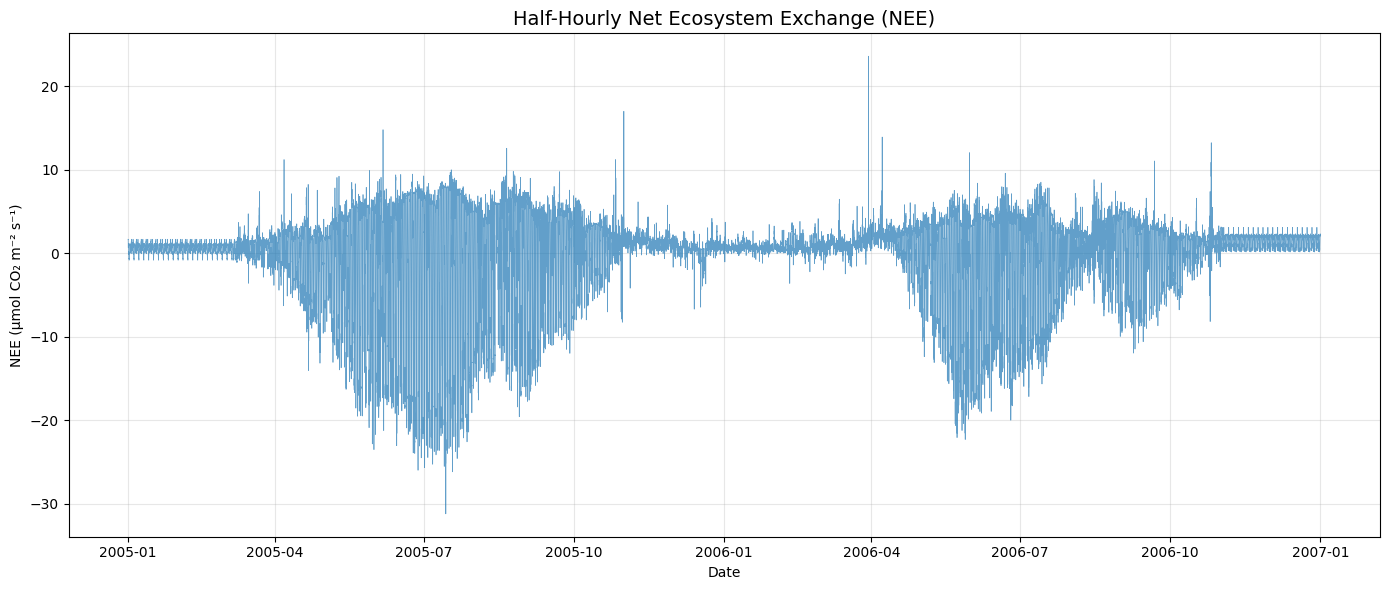

In [10]:
# Create time series plots for key variables
if "hh_data" in locals() and "NEE_VUT_REF" in hh_data.columns:
    # Single variable plot - Net Ecosystem Exchange
    plt.figure(figsize=(14, 6))
    plt.plot(hh_data["TIMESTAMP_START"], hh_data["NEE_VUT_REF"], alpha=0.7, linewidth=0.5)
    plt.title("Half-Hourly Net Ecosystem Exchange (NEE)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("NEE (μmol CO₂ m⁻² s⁻¹)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("NEE data not available for plotting.")

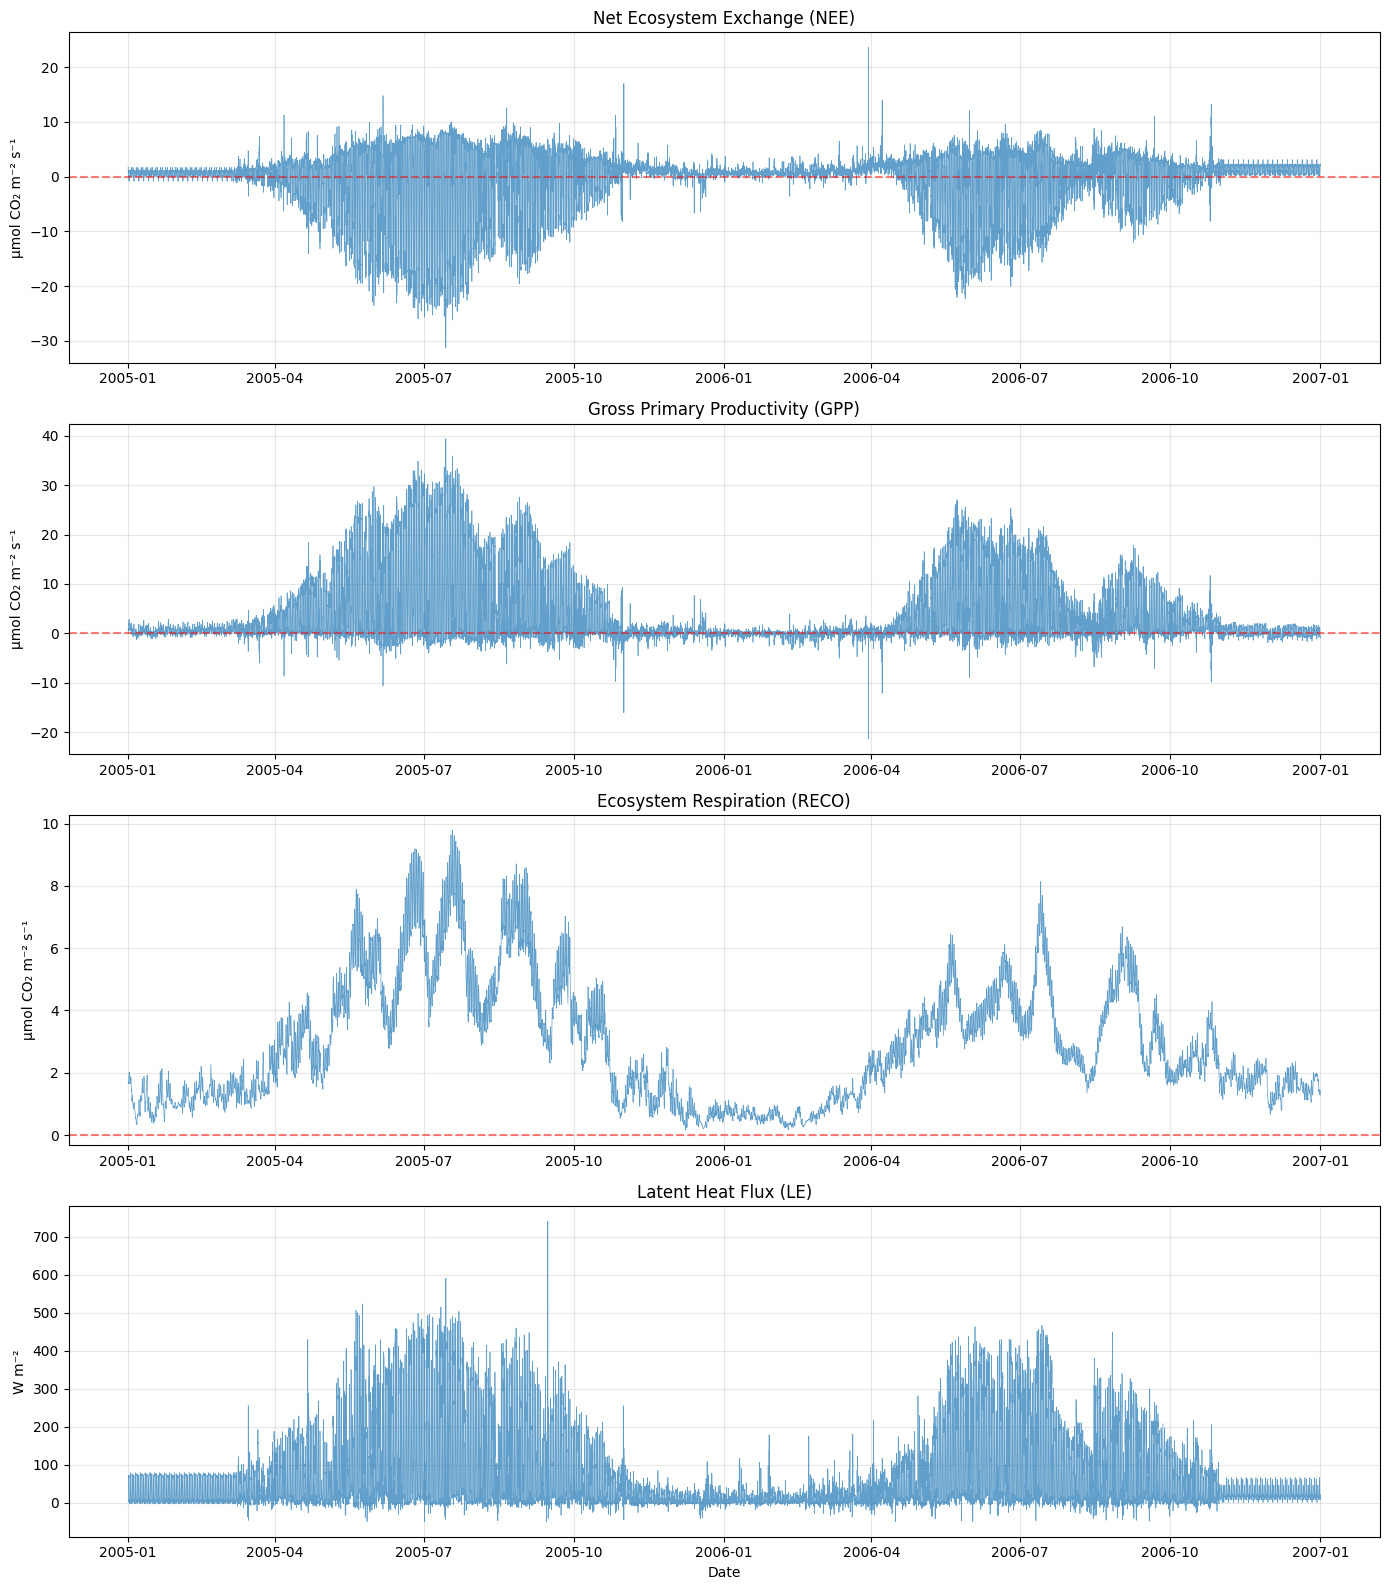

In [25]:
# Multi-panel plot for carbon cycle components
if "hh_data" in locals():
    # Define variables to plot
    plot_vars = [
        ("NEE_VUT_REF", "Net Ecosystem Exchange (NEE)", "μmol CO₂ m⁻² s⁻¹"),
        ("GPP_NT_VUT_REF", "Gross Primary Productivity (GPP)", "μmol CO₂ m⁻² s⁻¹"),
        ("RECO_NT_VUT_REF", "Ecosystem Respiration (RECO)", "μmol CO₂ m⁻² s⁻¹"),
        ("LE_F_MDS", "Latent Heat Flux (LE)", "W m⁻²"),
    ]

    # Filter to available variables
    available_plots = [(var, title, unit) for var, title, unit in plot_vars if var in hh_data.columns]

    if available_plots:
        n_plots = len(available_plots)
        fig, axes = plt.subplots(n_plots, 1, figsize=(14, 4 * n_plots))

        if n_plots == 1:
            axes = [axes]

        for i, (var, title, unit) in enumerate(available_plots):
            axes[i].plot(hh_data["TIMESTAMP_START"], hh_data[var], alpha=0.7, linewidth=0.5)
            axes[i].set_title(title, fontsize=12)
            axes[i].set_ylabel(unit)
            axes[i].grid(True, alpha=0.3)

            # Add horizontal line at zero for flux variables
            if "CO₂" in unit:
                axes[i].axhline(y=0, color="red", linestyle="--", alpha=0.5)

        axes[-1].set_xlabel("Date")
        plt.tight_layout()
        plt.show()
    else:
        print("No suitable variables available for multi-panel plotting.")

## Step 8: Monthly Aggregation Example

Demonstrate how to aggregate half-hourly data to monthly means for longer-term analysis.

Monthly aggregated data:
  Shape: (24, 3)
  Date range: 2005-01-31 00:00:00 to 2006-12-31 00:00:00


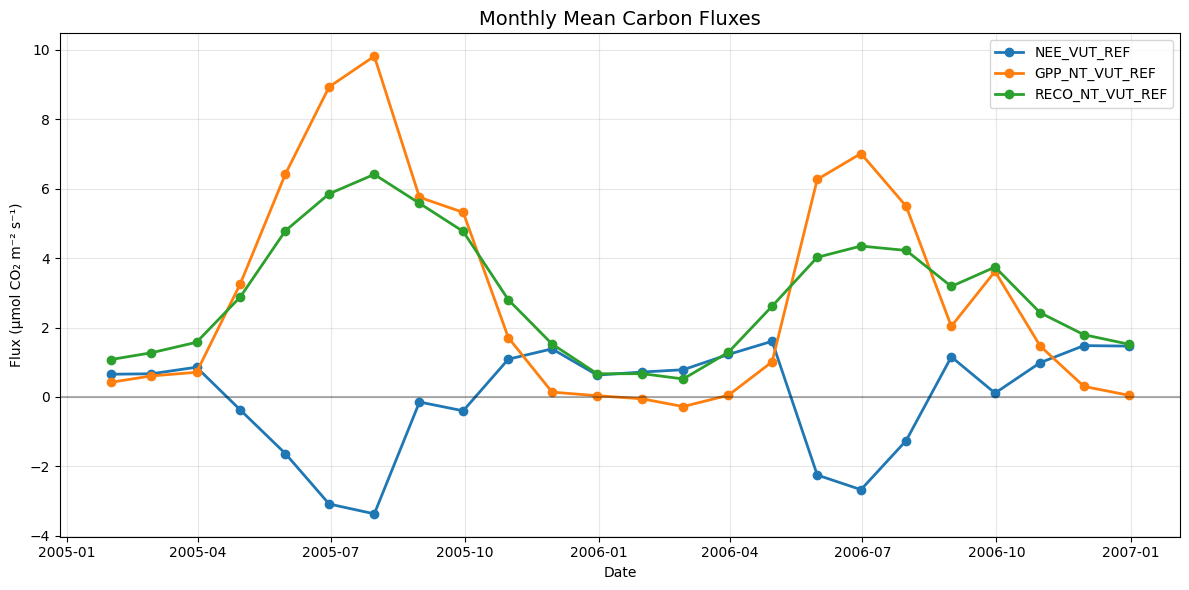

In [11]:
# Create monthly aggregations
if "hh_data" in locals() and "NEE_VUT_REF" in hh_data.columns:
    # Set timestamp as index for resampling
    hh_data_indexed = hh_data.set_index("TIMESTAMP_START")

    # Calculate monthly means for key variables
    monthly_vars = ["NEE_VUT_REF", "GPP_NT_VUT_REF", "RECO_NT_VUT_REF"]
    available_monthly_vars = [var for var in monthly_vars if var in hh_data_indexed.columns]

    if available_monthly_vars:
        monthly_data = hh_data_indexed[available_monthly_vars].resample("M").mean()

        print(f"Monthly aggregated data:")
        print(f"  Shape: {monthly_data.shape}")
        print(f"  Date range: {monthly_data.index.min()} to {monthly_data.index.max()}")

        # Plot monthly data
        fig, ax = plt.subplots(figsize=(12, 6))
        for var in available_monthly_vars:
            ax.plot(monthly_data.index, monthly_data[var], marker="o", label=var, linewidth=2)

        ax.set_title("Monthly Mean Carbon Fluxes", fontsize=14)
        ax.set_xlabel("Date")
        ax.set_ylabel("Flux (μmol CO₂ m⁻² s⁻¹)")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color="black", linestyle="-", alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Display monthly data table
        monthly_data
    else:
        print("No carbon flux variables available for monthly aggregation.")
else:
    print("Data not available for monthly aggregation.")

## Summary

This notebook demonstrated the complete workflow for using the FLUXNET Shuttle Library:

1. **Data Discovery**: Used `listall()` to query AmeriFlux and ICOS APIs for available datasets
2. **Site Selection**: Examined the data catalog and selected specific sites for download
3. **Data Download**: Used `download()` to retrieve FLUXNET data files
4. **Data Extraction**: Extracted and examined the contents of downloaded zip files
5. **Data Analysis**: Loaded half-hourly eddy covariance data with proper parsing
6. **Quality Assessment**: Evaluated data coverage and basic statistics
7. **Visualization**: Created time series plots of key carbon and energy fluxes
8. **Aggregation**: Demonstrated monthly aggregation for longer-term analysis

## Next Steps

- Explore additional variables in the dataset (meteorological, soil, etc.)
- Apply gap-filling techniques for missing data
- Compare fluxes across different sites and ecosystems
- Integrate with other ecological or climate datasets
- Perform uncertainty analysis using quality flags

## Additional Resources

- [FLUXNET Data Processing](https://fluxnet.org/data/fluxnet2015-dataset/)
- [AmeriFlux Data Portal](https://ameriflux.lbl.gov/)
- [ICOS Carbon Portal](https://www.icos-cp.eu/)
- [Eddy Covariance Methodology](https://www.licor.com/env/support/EddyPro/topics/introduction.html)